In [1]:
#This notebook took 11 minutes and 30 seconds to run from fresh. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import metrics
from sklearn import model_selection, naive_bayes, svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

#nltk.download('all')

In [4]:
NewsHeadlines1 = pd.read_csv("C:/Users/Pauly/Downloads/22166475_Paul_Long_Final_Project_ML/Text_Data.csv")
NewsHeadlines2 = pd.read_excel("C:/Users/Pauly/Downloads/22166475_Paul_Long_Final_Project_ML/Text_Data_Aux.xlsx")

NewsHeadlinesFull = pd.merge(NewsHeadlines1,NewsHeadlines2,on='website')
NewsHeadlinesFull = NewsHeadlinesFull.sort_values("id")

NewsHeadlinesFull = NewsHeadlinesFull[['id', 'website', 'headline', 'political bias']]
NewsHeadlinesFull.head()

,id,website,headline,political bias
0,1,BBC,Mystery surrounds objects shot down by US mili...,left-center
1,2,BBC,China says US balloons breached airspace at le...,left-center
2,3,BBC,"Brianna's death has left massive hole, says fa...",left-center
3,4,BBC,Wegovy weight loss jab to be sold by UK chemis...,left-center
4,5,BBC,Meteoroid lights up sky above English Channel,left-center


In [5]:
#Remove center papers as not enough papers & only one paper
NewsHeadlines = NewsHeadlinesFull.loc[NewsHeadlinesFull['political bias'] != 'center']

#NewsHeadlines = NewsHeadlinesFull.sample(n=10000) 
NewsHeadlines = NewsHeadlines.sort_values(by=['id'])
NewsHeadlines = NewsHeadlines.reset_index()
NewsHeadlines = NewsHeadlines.drop('index', axis=1)

NewsHeadlines['headline'].dropna(inplace=True)
NewsHeadlines['headline'] = [entry.lower() for entry in NewsHeadlines['headline']]

In [ ]:
#Exploratory Data Analysis

<AxesSubplot:>

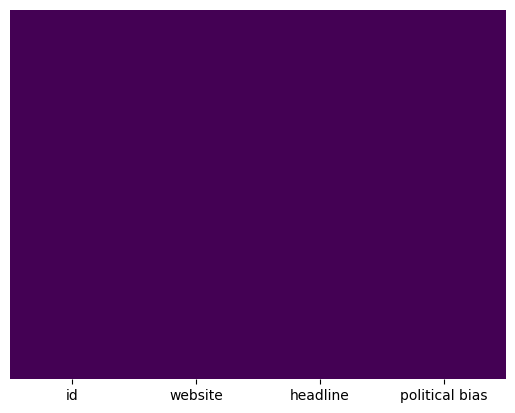

In [6]:
sns.heatmap(NewsHeadlines.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [7]:
print(NewsHeadlines['political bias'].unique(),
      NewsHeadlines['website'].unique())

['left-center' 'right' 'right-center'] ['BBC' 'Sun' 'Mirror' 'Daily Mail' 'Independent' 'Guardian'
 'Manchester Evening News' 'Metro' 'Telegraph' 'Daily Express' 'Times'
 'Liverpool Echo' 'Birmingham Live' 'Evening Standard']


In [8]:
NewsHeadlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32796 entries, 0 to 32795
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32796 non-null  int64 
 1   website         32796 non-null  object
 2   headline        32796 non-null  object
 3   political bias  32796 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


<AxesSubplot:xlabel='political bias', ylabel='count'>

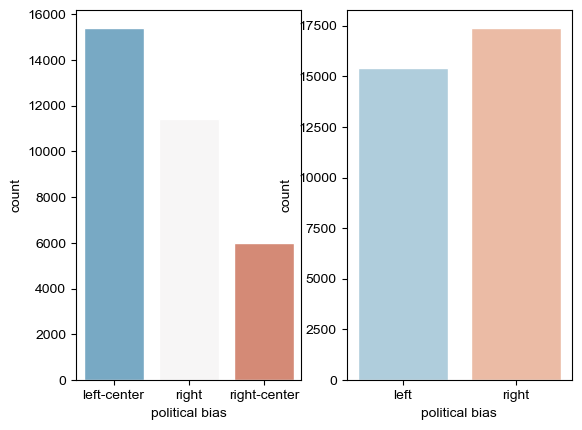

In [9]:
NewsHeadlinesDouble = NewsHeadlines.copy()
NewsHeadlinesDouble = NewsHeadlinesDouble.replace('right-center', 'right')
NewsHeadlinesDouble = NewsHeadlinesDouble.replace('left-center', 'left')

fig, axis = plt.subplots(ncols=2)
sns.set_style('whitegrid')
sns.countplot(x='political bias', data=NewsHeadlines, palette='RdBu_r', ax=axis[0])
sns.countplot(x='political bias', data=NewsHeadlinesDouble, palette='RdBu_r', ax=axis[1])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'BBC'),
  Text(1, 0, 'Sun'),
  Text(2, 0, 'Mirror'),
  Text(3, 0, 'Daily Mail'),
  Text(4, 0, 'Independent'),
  Text(5, 0, 'Guardian'),
  Text(6, 0, 'Manchester Evening News'),
  Text(7, 0, 'Metro'),
  Text(8, 0, 'Telegraph'),
  Text(9, 0, 'Daily Express'),
  Text(10, 0, 'Times'),
  Text(11, 0, 'Liverpool Echo'),
  Text(12, 0, 'Birmingham Live'),
  Text(13, 0, 'Evening Standard')])

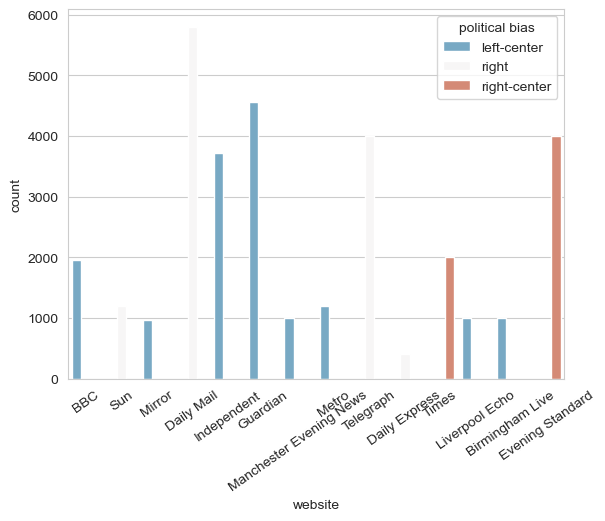

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='website',hue='political bias',data=NewsHeadlines,palette='RdBu_r')
plt.xticks(rotation=35)

In [11]:
totalwords = []
NewsHeadlinessplit = []

for i in range(0, len(NewsHeadlines['headline'])):
    NewsHeadlinessplit.append(NewsHeadlines['headline'][i].split())

NewsHeadlinessplit = pd.DataFrame(NewsHeadlinessplit)

for i in range(0, len(NewsHeadlinessplit[0])):
    for w in range(0, 28):
        totalwords.append(NewsHeadlinessplit[w][i])

totalwords = pd.DataFrame(totalwords)
print(len(totalwords[0].unique()))

36173


In [12]:
#Tokenize
NewsHeadlines['Tokenized Headline'] = [word_tokenize(entry) for entry in NewsHeadlines['headline']]

In [13]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [14]:
for index,entry in enumerate(NewsHeadlines['Tokenized Headline']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    NewsHeadlines.loc[index,'Finalised Headline'] = str(Final_words)

In [15]:
#Train Test Split
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(
    NewsHeadlines['Finalised Headline'],NewsHeadlines['political bias'],test_size=0.3)

In [16]:
#Count Vectoriser (Bag of Words)
Train_Y_CV = Train_Y
Test_Y_CV = Test_Y

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase = True, stop_words= 'english', 
                     ngram_range = (1,2), tokenizer = token.tokenize) #Use 1 and 2 word features
Train_X_CV = cv.fit_transform(Train_X)
Test_X_CV = cv.transform(Test_X)

In [17]:
#Term Frequency - Inverse Document Frequency

#https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
Encoder = LabelEncoder()
Train_Y_TF = Encoder.fit_transform(Train_Y)
Test_Y_TF = Encoder.fit_transform(Test_Y)

TF_vect = TfidfVectorizer(max_features = 15000)
TF_vect.fit(NewsHeadlines['Finalised Headline'])
Train_X_TF = TF_vect.transform(Train_X)
Test_X_TF = TF_vect.transform(Test_X)


In [18]:
# Logistic Regression
classifier = LogisticRegression()

In [19]:
LR_CV = classifier.fit(Train_X_CV,Train_Y_CV)
predictions_LR_CV = LR_CV.predict(Test_X_CV)
print("LR CV Accuracy:",accuracy_score(predictions_LR_CV, Test_Y_CV))
print("LR CV Accuracy:\n",classification_report(predictions_LR_CV, Test_Y_CV))


C:\Users\pauly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR CV Accuracy: 0.739810956398008
LR CV Accuracy:
               precision    recall  f1-score   support

 left-center       0.80      0.73      0.76      5041
       right       0.76      0.77      0.77      3420
right-center       0.55      0.71      0.62      1378

    accuracy                           0.74      9839
   macro avg       0.70      0.74      0.72      9839
weighted avg       0.75      0.74      0.74      9839



In [21]:
LR_TF = classifier.fit(Train_X_TF,Train_Y_TF)
predictions_LR_TF = LR_TF.predict(Test_X_TF)
print("LR TF Accuracy:",metrics.accuracy_score(predictions_LR_TF, Test_Y_TF))

LR TF Accuracy: 0.6880780567130806


C:\Users\pauly\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
#K Nearest Neighbours
KNN = KNeighborsClassifier(n_neighbors=5) #5 neighbours were used. 

In [23]:
KNN_CV = KNN.fit(Train_X_CV,Train_Y_CV)
predictions_KNN_CV = KNN_CV.predict(Test_X_CV)
print("K Nearest Neighbours CV Accuracy:",accuracy_score(predictions_KNN_CV, Test_Y_CV))
print("K Nearest Neighbours CV Classification Report:\n",classification_report(predictions_KNN_CV, Test_Y_CV))

C:\Users\pauly\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Nearest Neighbours CV Accuracy: 0.5893891655656063
K Nearest Neighbours CV Classification Report:
               precision    recall  f1-score   support

 left-center       0.96      0.54      0.69      8182
       right       0.20      0.79      0.32       877
right-center       0.39      0.88      0.54       780

    accuracy                           0.59      9839
   macro avg       0.52      0.74      0.52      9839
weighted avg       0.85      0.59      0.65      9839



In [24]:
KNN_TF = KNN.fit(Train_X_TF,Train_Y_TF)
predictions_KNN_TF = KNN_TF.predict(Test_X_TF)
print("K Nearest Neighbours TF Accuracy:",accuracy_score(predictions_KNN_TF, Test_Y_TF))

C:\Users\pauly\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


K Nearest Neighbours TF Accuracy: 0.6545380628112613


In [25]:
# Random Forest
RF = RandomForestClassifier(n_estimators = 20)#20 Trees were used as a balance between processing time & accuracy

In [26]:
RF_CV = RF.fit(Train_X_CV,Train_Y_CV)
predictions_RF_CV = RF_CV.predict(Test_X_CV)
print("RF CV Accuracy:",metrics.accuracy_score(predictions_RF_CV, Test_Y_CV))

RF CV Accuracy: 0.725581868076024


In [27]:
RF_TF = RF.fit(Train_X_TF,Train_Y_TF)
predictions_RF_TF = RF_TF.predict(Test_X_TF)
print("RF TF Accuracy:",metrics.accuracy_score(predictions_RF_TF, Test_Y_TF))

RF TF Accuracy: 0.725480231730867


In [28]:
#Naive Bayes
NaiveBayes = naive_bayes.MultinomialNB()

In [29]:
NaiveBayes.fit(Train_X_CV,Train_Y_CV)
predictions_NB_CV = NaiveBayes.predict(Test_X_CV)
print("Naive Bayes CV Accuracy :",accuracy_score(predictions_NB_CV, Test_Y_CV))

Naive Bayes CV Accuracy : 0.7243622319341396


In [30]:
NB_TF = NaiveBayes.fit(Train_X_TF,Train_Y_TF)
predictions_NB_TF = NB_TF.predict(Test_X_TF)
print("Naive Bayes TF Accuracy :",accuracy_score(predictions_NB_TF, Test_Y_TF))
print("\nNaive Bayes TF Classification Report :\n",classification_report(predictions_NB_TF, Test_Y_TF))

Naive Bayes TF Accuracy : 0.6613476979367822

Naive Bayes TF Classification Report :
               precision    recall  f1-score   support

           0       0.90      0.61      0.73      6778
           1       0.51      0.75      0.61      2351
           2       0.35      0.87      0.50       710

    accuracy                           0.66      9839
   macro avg       0.58      0.74      0.61      9839
weighted avg       0.76      0.66      0.68      9839



In [31]:
#Support Vector Machine Classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto') #parameters given as default

In [32]:
SVM_CV = SVM.fit(Train_X_CV,Train_Y_CV)
predictions_SVM_CV = SVM_CV.predict(Test_X_CV)
print("Support Vector Machine CV Accuracy :",accuracy_score(predictions_SVM_CV, Test_Y_CV))
print("\nSupport Vector Machine CV Classification Report :\n",classification_report(predictions_SVM_CV, Test_Y_CV))

Support Vector Machine CV Accuracy : 0.7358471389368838

Support Vector Machine CV Classification Report :
               precision    recall  f1-score   support

 left-center       0.79      0.72      0.76      5059
       right       0.75      0.77      0.76      3357
right-center       0.55      0.69      0.61      1423

    accuracy                           0.74      9839
   macro avg       0.70      0.73      0.71      9839
weighted avg       0.75      0.74      0.74      9839



In [33]:
SVM_TF = SVM.fit(Train_X_TF,Train_Y_TF)
predictions_SVM_TF = SVM_TF.predict(Test_X_TF)
print("SVM TF Accuracy :",accuracy_score(predictions_SVM_TF, Test_Y_TF))

SVM TF Accuracy : 0.692854964935461
